<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
drive.mount('/content/drive')
train = get_training_data('/content/drive/MyDrive/Pneumonia/train')
test = get_training_data('/content/drive/MyDrive/Pneumonia/test')
val = get_training_data('/content/drive/MyDrive/Pneumonia/val')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 1359/1359 [01:03<00:00, 21.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app
100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


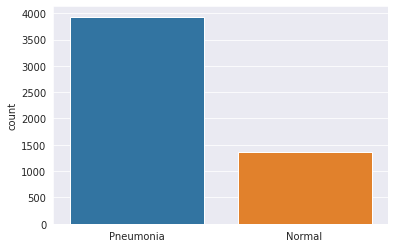

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True)  # randomly flip images)  # randomly flip images

null_datagen = ImageDataGenerator()

In [26]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32) 
steps_per_epoch = balanced_gen.steps_per_epoch #generated_image, label = train.__getitem__(18)
y_gen = [balanced_gen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True)) #number of each label changes every training *

(array([0, 1]), array([3921, 3919]))


In [34]:
#imbalance augmentation
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = null_datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
166/166 [==============================] - 8s 38ms/step - loss: 0.5114 - accuracy: 0.8968 - val_loss: 27.6408 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
166/166 [==============================] - 6s 37ms/step - loss: 0.1388 - accuracy: 0.9586 - val_loss: 38.8508 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
165/166 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9658
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 6s 37ms/step - loss: 0.1102 - accuracy: 0.9660 - val_loss: 8.9257 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
166/166 [==============================] - 6s 37ms/step - loss: 0.0360 - accuracy: 0.9879 - val_loss: 0.5224 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 5/12
166/166 [==============================] - 6s 38ms/step - loss: 0.0230 - accuracy: 0.9913 - val_loss: 1.1337 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/12
166/166 [=============================

In [35]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 13ms/step - loss: 4.9058 - accuracy: 0.7500
Loss of the model is -  4.905815601348877
20/20 [==============================] - 0s 13ms/step - loss: 4.9058 - accuracy: 0.7500
Accuracy of the model is -  75.0 %


In [ ]:
# datagen.fit(x_train)
# train = datagen.flow(x_train,y_train, batch_size = 32)
# generated_image, label = train.__getitem__(18)
# print(label)
# for img in generated_image: 
#   plt.imshow(img[:,:,0], cmap='gray')
#   plt.show(block=True)

In [36]:
#balanced augmentation  
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(balanced_gen, epochs = 12 , validation_data = null_datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
245/245 [==============================] - 19s 72ms/step - loss: 0.4214 - accuracy: 0.8761 - val_loss: 27.3216 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
245/245 [==============================] - 19s 78ms/step - loss: 0.2130 - accuracy: 0.9279 - val_loss: 18.1330 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
245/245 [==============================] - 18s 72ms/step - loss: 0.1830 - accuracy: 0.9405 - val_loss: 0.3195 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/12
245/245 [==============================] - 20s 80ms/step - loss: 0.1522 - accuracy: 0.9489 - val_loss: 0.5720 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/12
245/245 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9500
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
245/245 [==============================] - 19s 78ms/step - loss: 0.1468 - accuracy: 0.9500 - val_loss: 0.5073 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/12
245/245 [==============================] 

In [37]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 13ms/step - loss: 0.3346 - accuracy: 0.9022
Loss of the model is -  0.33458212018013
20/20 [==============================] - 0s 13ms/step - loss: 0.3346 - accuracy: 0.9022
Accuracy of the model is -  90.22436141967773 %


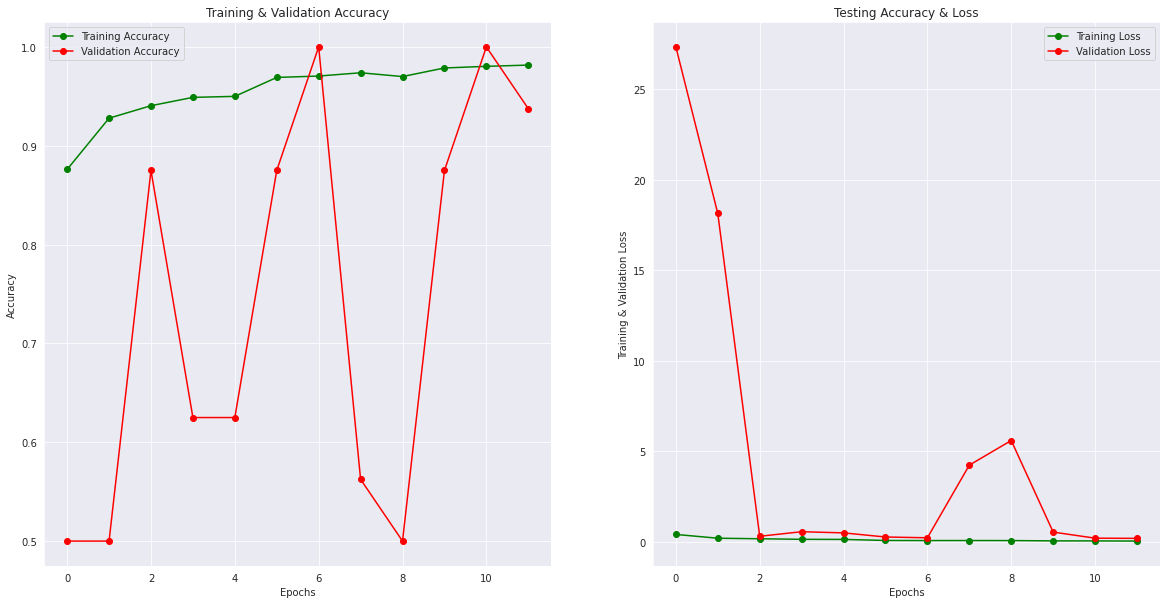

In [38]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [39]:
#no augmentation 
datagen = ImageDataGenerator() 
datagen.fit(x_train)

tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Epoch 1/12
166/166 [==============================] - 8s 39ms/step - loss: 0.4009 - accuracy: 0.8825 - val_loss: 38.3071 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
166/166 [==============================] - 6s 37ms/step - loss: 0.1427 - accuracy: 0.9520 - val_loss: 36.2959 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
165/166 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9698
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 6s 37ms/step - loss: 0.1051 - accuracy: 0.9696 - val_loss: 19.5633 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
166/166 [==============================] - 6s 37ms/step - loss: 0.0397 - accuracy: 0.9873 - val_loss: 1.9402 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/12
166/166 [==============================] - 6s 37ms/step - loss: 0.0284 - accuracy: 0.9904 - val_loss: 2.6453 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/12
166/166 [============================

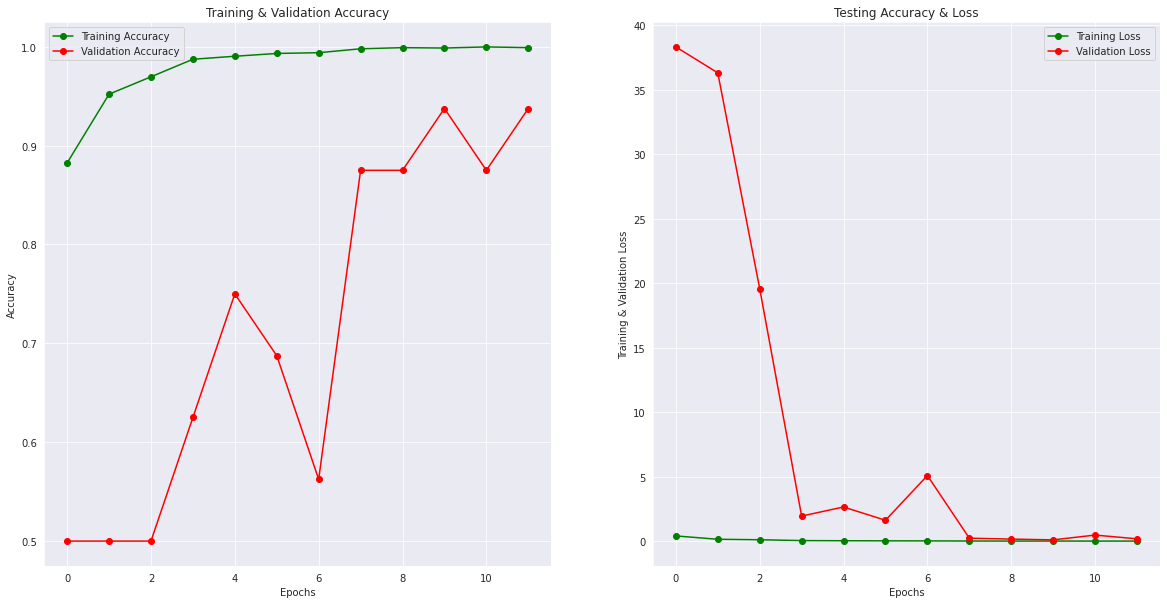

In [40]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()